In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

### Data loading


In [2]:
TRAIN_FILEPATH = os.path.join('..', 'input', 'train.csv')
TEST_FILEPATH = os.path.join('..', 'input', 'test.csv')

df_train = pd.read_csv(TRAIN_FILEPATH, index_col=0)
df_test = pd.read_csv(TEST_FILEPATH, index_col=0)

df_train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Data preprocessing

#### Gestion des outliers

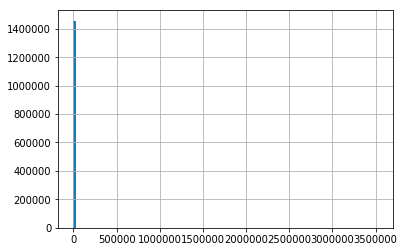

In [3]:
df_train["trip_duration"].hist(bins=100)

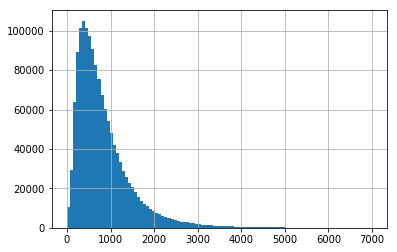

In [4]:
df_train.loc[df_train["trip_duration"] < 7000, "trip_duration"].hist(bins=100)

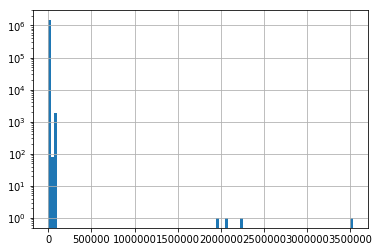

In [5]:
# Gestion des outliers
df_train['trip_duration'].hist(bins=100, log=True);

Cette transformation des données permet de mettre en évidence quelques outliers

#### Gestion des données manquantes

In [6]:
df_train.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Il n'ya aucune donnée manquante

In [7]:
df_train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Aucune donnée nulle

#### Gestion des données dupliquées

In [8]:
df_train.duplicated().sum()

7

In [9]:
df_train[df_train.duplicated()]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2386705,2,2016-03-06 10:06:31,2016-03-07 09:59:05,4,-73.997055,40.737183,-73.991913,40.734577,N,85954
id0946562,2,2016-03-05 18:22:41,2016-03-05 18:25:10,2,-73.997292,40.691071,-73.999428,40.683388,N,149
id1999875,2,2016-06-09 16:17:06,2016-06-09 16:24:22,2,-73.958359,40.778519,-73.947296,40.779682,N,436
id3429539,2,2016-05-04 14:54:59,2016-05-04 14:57:28,4,-73.958336,40.800922,-73.959106,40.801910,N,149
id0133335,2,2016-02-16 21:36:35,2016-02-16 21:37:06,2,-74.008034,40.723553,-74.008034,40.723553,N,31
id0146524,2,2016-03-12 16:41:35,2016-03-12 16:47:54,1,-73.974533,40.742298,-73.979507,40.750549,N,379
id0978620,2,2016-01-21 12:04:53,2016-01-21 13:35:06,3,-73.800667,40.645954,-73.985809,40.763363,N,5413


Il ne semble pas nécessaire de supprimer ces données. Aucune des colonnes ne semble être réellement en double dans ces données

#### Gestion des données catégoriques

In [10]:
# Gestion des données catégoriques
CAT_COL = "store_and_fwd_flag"
df_train[CAT_COL] = df_train[CAT_COL].astype('category').cat.codes
df_test[CAT_COL] = df_test[CAT_COL].astype('category').cat.codes

### Features engineering

#### Features creation

Création de la colonne "distance" qui contient la distance entre les coordonnées géographique de départ (pickup_latitude, pickup_longitude) et d'arrivée (dropoff_latitude, dropoff_longitude)

La formule donnée par Wikipédia pour calculer la distance à vol d'oiseau
$$M = 60\arccos \,[\sin(\varphi_A)\sin(\varphi_B) + \cos(\varphi_A)\cos(\varphi_B) \cos (\lambda_B - \lambda_A)]\,$$

In [11]:
import math

df_train["distance"] = ( np.arccos(np.sin(df_train['pickup_latitude']) * np.sin(df_train['dropoff_latitude']) + np.cos(df_train['pickup_latitude']) * np.cos(df_train['dropoff_latitude']) * np.cos(df_train['dropoff_longitude'] - df_train['pickup_longitude'] ) ) * 6371 ) * math.pi / 180
df_test["distance"] = ( np.arccos(np.sin(df_test['pickup_latitude']) * np.sin(df_test['dropoff_latitude']) + np.cos(df_test['pickup_latitude']) * np.cos(df_test['dropoff_latitude']) * np.cos(df_test['dropoff_longitude'] - df_test['pickup_longitude'] ) ) * 6371 ) * math.pi / 180
df_train["distance"].head(20)

c:\users\brendan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\brendan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.


id
id2875421    1.960598
id2377394    2.263533
id3858529    6.657294
id3504673    1.493929
id2181028    1.188626
id0801584    1.283106
id1813257    1.568241
id1324603    6.641624
id1301050    1.636762
id0012891    5.153968
id1436371    4.057720
id1299289    4.537564
id1187965    2.416281
id0799785    1.217951
id2900608    6.506379
id3319787    0.817720
id3379579    3.477243
id1154431    2.567959
id3552682    4.934710
id3390316    1.404529
Name: distance, dtype: float64

Création de la colonne "pickup_hour" et "pickup_day" car selon les jours et les heures (jours de travail, matin à 8h ou soir à 22h), le temps d'un trajet peut varier suivant le traffic routier

In [15]:
df_train["pickup_hour"] = pd.to_datetime(df_train.pickup_datetime).dt.hour
df_train["pickup_day"] = pd.to_datetime(df_train.pickup_datetime).dt.dayofweek

df_test["pickup_hour"] = pd.to_datetime(df_train.pickup_datetime).dt.hour
df_test["pickup_day"] = pd.to_datetime(df_train.pickup_datetime).dt.dayofweek

df_train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_hour,pickup_day
id,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.960598,17,0
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2.263533,0,6
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.657294,11,1
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.493929,19,2
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.188626,13,5


#### Features selection

In [16]:
FEATURES = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "pickup_hour", "pickup_day"]
TARGET = 'trip_duration'

In [17]:
X_train = df_train[FEATURES]
Y_train = df_train[TARGET]

X_test = df_test[FEATURES]

X_train.shape, Y_train.shape

((1458644, 6), (1458644,))

### Model Selection

In [18]:
from sklearn.ensemble import RandomForestRegressor

m1 = RandomForestRegressor(n_estimators=20)
m1.fit(X_train, Y_train)

MemoryError: could not allocate 100663296 bytes

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(m1, X_train, Y_train, cv=5, scoring='neg_mean_squared_log_error')
cv_scores

### Prediction

In [ ]:
predictions = m1.predict(X_test)
predictions[:10]

### Submission

In [ ]:
submission = pd.DataFrame({'id': df_test.index, 'trip_duration': predictions})
submission.to_csv('submission.csv', index=False)

submission.head()